In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

___
# Prepare data 

Info about the dataset: https://github.com/rfordatascience/tidytuesday/tree/master/data/2023/2023-02-14

Inspect the data and previous work: https://hollywoodagegap.com/

Dataset contains birth dates of actors playing in Hollywood movies in roles which involve being part of a couple

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-02-14/age_gaps.csv')

In [3]:
df.iloc[0]

movie_name            Harold and Maude
release_year                      1971
director                     Hal Ashby
age_difference                      52
couple_number                        1
actor_1_name               Ruth Gordon
actor_2_name                  Bud Cort
character_1_gender               woman
character_2_gender                 man
actor_1_birthdate           1896-10-30
actor_2_birthdate           1948-03-29
actor_1_age                         75
actor_2_age                         23
Name: 0, dtype: object

In [4]:
# convert to datetimes, extract the birth year

for col in ['actor_1_birthdate', 'actor_2_birthdate']: 
    df[col] = pd.to_datetime(df[col])
    
for col in ['actor_2_birthdate', 'actor_1_birthdate']: 
    df[col+'_year'] = df[col].dt.year

In [5]:
# gender flag for the couple: if same gender, output "s", otherwise output "m" if male is older, else "w" if woman is older 
# "e" for erroneous entries 

def gender_flag(char1g, char2g): 
    if char1g == char2g: 
        out = 's'
    else: 
        if char1g == 'man': 
            out = 'm'
        elif char1g == 'woman': 
            out = 'w'
        else: 
            out = 'e'
    return out 

# character_1 is always older 
df['gender_flag'] = df.apply(lambda x: gender_flag(x['character_1_gender'], x['character_2_gender']), axis=1)

In [6]:
df.iloc[0]

movie_name                   Harold and Maude
release_year                             1971
director                            Hal Ashby
age_difference                             52
couple_number                               1
actor_1_name                      Ruth Gordon
actor_2_name                         Bud Cort
character_1_gender                      woman
character_2_gender                        man
actor_1_birthdate         1896-10-30 00:00:00
actor_2_birthdate         1948-03-29 00:00:00
actor_1_age                                75
actor_2_age                                23
actor_2_birthdate_year                   1948
actor_1_birthdate_year                   1896
gender_flag                                 w
Name: 0, dtype: object

`actor_1`: older actor 

___ 
## Exploration

<span style="background:DarkSeaGreen">Question: When were those actors born?</span>

Story angle: <span style="background:salmon">scale</span> and <span style="background:salmon">variation</span> -> use histogram as the first step

In [7]:
year_range_common = np.arange(1895, 2025, 5)

<Axes: >

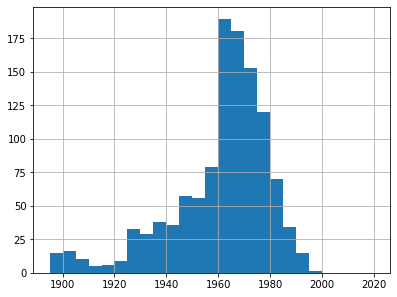

In [8]:
df['actor_1_birthdate_year'].hist(bins=year_range_common)

<Axes: >

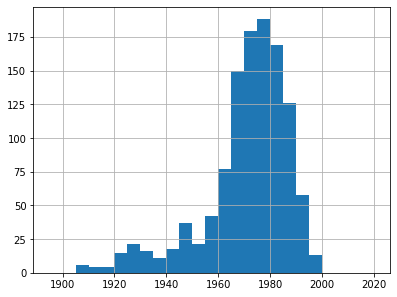

In [9]:
df['actor_2_birthdate_year'].hist(bins=year_range_common)

Follow-up storytelling question (distributions - <span style="background:salmon">min and max</span>): <span style="background:DarkSeaGreen">who is the oldest in the dataset? the youngest?</span>
-> this data structure doesn't show it optimally, because we have `actor_1` and `actor_2` split -> back to the data manipulation

In [10]:
all_actors = pd.concat([df[['actor_1_birthdate_year', 'actor_1_name']]\
               .rename(columns={'actor_1_birthdate_year':'actor_birthdate_year', 'actor_1_name': 'actor_name'}), 
          df[['actor_2_birthdate_year', 'actor_2_name']]\
               .rename(columns={'actor_2_birthdate_year':'actor_birthdate_year', 'actor_2_name': 'actor_name'}), 
            ], axis=0)\
    .reset_index()\
    .rename(columns={'index': 'film_id'})

In [11]:
unique_actors = all_actors.groupby(['actor_name', 'actor_birthdate_year'])['film_id'].nunique()\
    .rename('num_movies')\
    .reset_index()

In [12]:
unique_actors.head()

,actor_name,actor_birthdate_year,num_movies
0,Aaron Eckhart,1968,3
1,Aaron Stanford,1976,2
2,Aaron Taylor-Johnson,1990,2
3,Adam Driver,1983,1
4,Adam Garcia,1973,1


<Axes: >

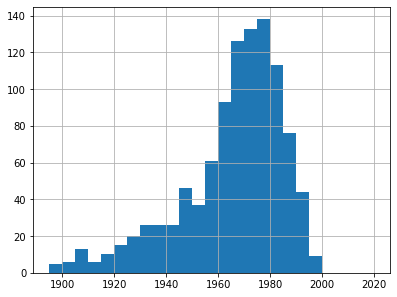

In [13]:
unique_actors['actor_birthdate_year'].hist(bins=year_range_common)

"For free" I get the metadata about number of movies

This data structure has opened another side question - <span style="background:DarkSeaGreen">who is the most popular actor?</span> (storytelling angle -> <span style="background:salmon">ranking</span>)

In [14]:
unique_actors.sort_values(by='num_movies', ascending=False).head(10)

,actor_name,actor_birthdate_year,num_movies
562,Keanu Reeves,1964,27
5,Adam Sandler,1966,20
886,Sean Connery,1930,17
853,Roger Moore,1927,17
618,Leonardo DiCaprio,1974,17
564,Keira Knightley,1985,14
811,Pierce Brosnan,1953,14
884,Scarlett Johansson,1984,13
833,Reese Witherspoon,1976,13
374,Harrison Ford,1942,13


Keanu 27, much more compared to the others. <span style="background:DarkSeaGreen">Does it mean that some male actors are casted unproportionally frequently?</span>

And only 3 women in the top10 actors... is the <span style="background:DarkSeaGreen">distribution split by gender</span> different? But if we want a split by gender, we need to have a different data structure! again, back to the analysis... (but postpone it for now) 

<span style="background:DarkSeaGreen">What is the typical value for # of times of being hired to play in a romantic couple?</span> let's see the <span style="background:salmon">distribution</span>: 

<Axes: >

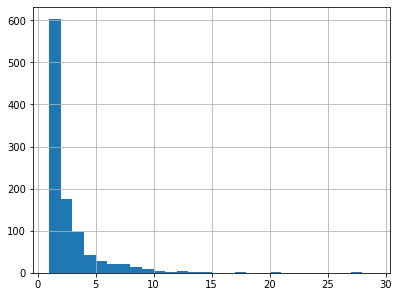

In [15]:
unique_actors['num_movies'].hist(bins=np.arange(1,30,1))

Storytelling questions we have identified so far:  
- are some actors casted unproportionally frequently in romantic settings? 
- who is the most/least frequent actor cast? 
- how does it differ by gender? 

___

Follow-up question: 
- we have looked at the actors birth year, but what about the relation between <span style="background:DarkSeaGreen">when the movie was made and how old was the actor at the time they have been cast?</span> (storytelling angle -> <span style="background:salmon">relationships</span>)

When were the films made?

<Axes: >

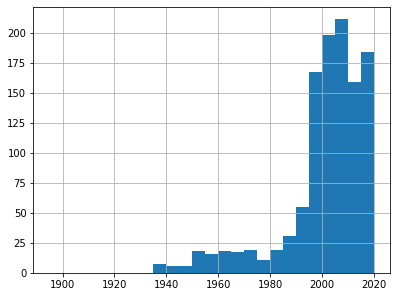

In [16]:
df['release_year'].hist(bins=year_range_common)

Calculate actor's age at the time of the movie: 

In [17]:
age_at_movie = \
    pd.concat([
        df[['release_year', 'actor_1_age']].rename(columns={'actor_1_age': 'actor_age'}), 
        df[['release_year', 'actor_2_age']].rename(columns={'actor_2_age': 'actor_age'})
        ], axis=0)\
    .reset_index()

<Axes: >

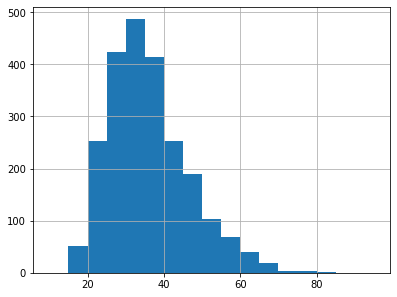

In [18]:
age_at_movie['actor_age'].hist(bins=np.arange(10,100,5))

Follow-up questions:  
- <span style="background:DarkSeaGreen">the youngest cast? the oldest?</span> (storytelling angle -> <span style="background:salmon">ranking</span>)


___

<span style="background:DarkSeaGreen">How did it change in time?</span> (angle: <span style="background:salmon">trends</span>) Did the directors and producers have differing preferences for older/younger actors in different decades? 

Approach 1 (crude): group old movies and young movies together across a threshold 

<Axes: >

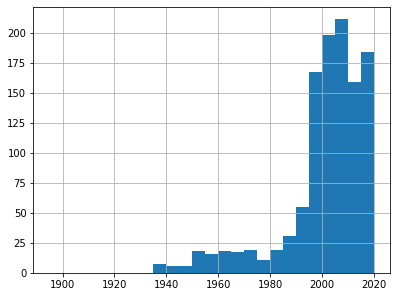

In [19]:
# again, how did the histogram look like? 
df['release_year'].hist(bins=year_range_common)

Experiment: 

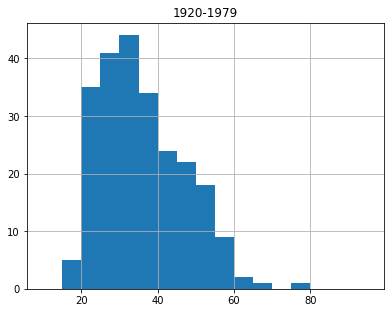

In [20]:
filmyear1, filmyear2 = [1920, 1979]
# filmyear1, filmyear2 = [1980, 1999]
# filmyear1, filmyear2= [2000, 2020]

ax = age_at_movie[age_at_movie['release_year'].isin(np.arange(filmyear1,filmyear2+1,1))]\
    ['actor_age'].hist(bins=np.arange(10,100,5))
ax.set_title(f'{filmyear1}-{filmyear2}');

Difficult to compare - let's normalize and overplot

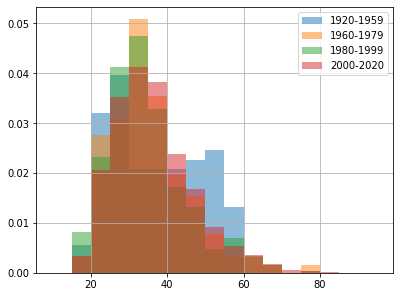

In [21]:
year_bins = [[1920, 1959], [1960, 1979], [1980, 1999],  [2000, 2020]]

f, ax = plt.subplots()
for filmyear1, filmyear2 in year_bins: 
    age_at_movie[age_at_movie['release_year'].isin(np.arange(filmyear1,filmyear2+1,1))]\
        ['actor_age']\
        .hist(
            bins=np.arange(10,100,5), 
            ax=ax, alpha=0.5, 
            density=True, 
            label=f'{filmyear1}-{filmyear2}')

ax.legend()

There may be a trend, but it's still difficult to see... we would need to look for a better chart: small multiples

In [24]:
year_bins = [[1920, 1959], [1960, 1979], [1980, 1999],  [2000, 2020]]

f, ax = plt.subplots(nrows=len(year_bins), figsize=(4,8), sharey=True)

for i, (filmyear1, filmyear2) in enumerate(year_bins): 
    this_ax = ax[i]
    age_at_movie[age_at_movie['release_year'].isin(np.arange(filmyear1,filmyear2+1,1))]\
        ['actor_age']\
        .hist(
            bins=np.arange(10,100,5), 
            ax=this_ax, alpha=0.5, 
            density=True, 
            label=f'{filmyear1}-{filmyear2}')
    this_ax.legend()

IndentationError: unexpected indent (2569596465.py, line 9)

Better, but not perfect

Maybe a line chart would be even better, but with data from other time periods as a background?  

Or maybe a few scatter clouds arranged vertically, with actor age on the y-axis and movie year range on the x-axis?  
-> try it out; also, go back to the "roots" - chart catalogues, encodings, etc. 

Note: At this point it starts to make sense to structure the code into functions and other re-usable chunks 

Our hypothesis / red thread for a data story by now: older movies showed high percentage of older people cast in romantic roles. In the 60s-70s, the peak age for an actor seen in a romantic role was 30-40 yo. In the 80s and 90s, more younger people were cast. In the 2000s-2020s, again more 40+ people. But still a stark contrast to the 1920-1959, where the distribution seems almost bimodal.  
-> Storytelling angle: change and variation  
-> maybe though there is a better chart, e.g. a slope graph, to show this relationship? (calculate values like mode, median, avg and look at their relations) -> close the loop between data transformation and visualization again 

It seems interesting. This could be the final chart of the story. We need to think about what does the reader need to know about this dataset and its context in order to comprehend this chart and appreciate its insight? Maybe there are some articles about how the directors in different decades thought about casting younger or older actors in particular story settings? 

This background information would form the first part of the data story and could be supplemented with other charts. Maybe we can even re-use some of the distributions we have used in the exploration, but adapted graphically to the final chart. 

There are also some follow-up questions if we want to continue with the investigation:  
- <span style="background:DarkSeaGreen">what about an age difference within the couple?</span>
- <span style="background:DarkSeaGreen">does it differ between same-sex and mixed couples?</span>
- ...

Some other alternative angles that could be interesting: 

- <span style="background:DarkSeaGreen">proportion of movies per actor which did or did not have him/her forming a couple</span> (e.g. Sylvester Stallone)
- extend it with a dataset about the <span style="background:DarkSeaGreen">movie genre, topic</span>
- extend it with data about <span style="background:DarkSeaGreen">movie and actors earnings</span>
- how about <span style="background:DarkSeaGreen">the age of actors in non-romantic roles? is there a similar actor-age preference for a particular decade?</span>
- is it reflected <span style="background:DarkSeaGreen">in depiction of actors e.g. in advertisements? </span>
- ... 